# Ray Based Simulation

In [4]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import arlpy.uwapm as pm
import arlpy.plot as aplt
import numpy as np
from oceans.sw_extras import sw_extras as sw
from pyat_tools import pyat_tools
from scipy import signal
import scipy
from tqdm import tqdm
import ODLintake
from scipy import interpolate
from tqdm import tqdm
import pickle

In [12]:
# Get soundspeed profile
ds = xr.open_mfdataset('/datadrive/HYCOM_data/DAS_30000/*.nc', decode_times=False).mean('time', keepdims=True)
sspx = sw.soundspeed(ds.salinity, ds.water_temp, ds.depth)

In [310]:
ssp = pyat_tools.convert_SSP_arlpy(sspx, time_idx=0)[1:,:]
ssp = np.vstack((ssp, np.array([600, ssp[-1,1]])))

In [24]:
pm.models()

STOP Fatal Error: Check the print file for details


['bellhop']

### Get bathy

In [328]:
fn = '/datadrive/DAS/south_DAS_latlondepth.txt'
geo = pd.read_csv(fn)
geo['distance'] = geo['index']*2.0419046878814697

df_idx_60km = (geo['distance'] - 60000).abs().argmin()

bathy_pd = geo.loc[df_idx_60km:df_idx_60km+1500][['distance','depth']]
bathy_pd['depth'] = bathy_pd['depth']*-1
bathy_pd['distance'] = bathy_pd['distance']-np.array(bathy_pd['distance'])[0]

In [369]:
bathy = np.array(bathy_pd)

env = pm.create_env2d(
    depth=bathy,
    soundspeed=ssp,
    bottom_soundspeed=1450,
    bottom_density=1200,
    bottom_absorption=1.0,
    tx_depth=499.9999,
    rx_depth=499.9999,
    rx_range=500,
    nbeams=500
)

In [370]:
pm.plot_ssp(env, width=300, title='sound speed profile')
pm.plot_env(env)

In [372]:
eigen_rays = pm.compute_eigenrays(env)
pm.plot_rays(eigen_rays, env=env, width=900)

STOP Fatal Error: Check the print file for details


In [254]:
arrivals = pm.compute_arrivals(env)

# account for sensor directivity
arrivals['arrival_amplitude'] = arrivals['arrival_amplitude'] * np.cos(np.deg2rad(arrivals['angle_of_arrival']))**2

STOP Fatal Error: Check the print file for details


In [255]:
#arrivals['arrival_amplitude'] = arrivals['arrival_amplitude'] * np.cos(np.deg2rad(arrivals['angle_of_arrival']))**2

In [256]:
arrivals

,tx_depth_ndx,rx_depth_ndx,rx_range_ndx,tx_depth,rx_depth,rx_range,arrival_number,arrival_amplitude,time_of_arrival,angle_of_departure,angle_of_arrival,surface_bounces,bottom_bounces
1,0,0,0,499.999908,499.999908,500.0,0,-9.742506e-08+2.842819e-08j,1.390526,-76.152306,-76.153069,2,2
2,0,0,0,499.999908,499.999908,500.0,1,-7.669963e-07+7.331096e-07j,1.390527,-75.831665,75.832169,2,1
3,0,0,0,499.999908,499.999908,500.0,2,7.926491e-06-3.626550e-06j,0.754119,-63.647293,-63.648224,1,1
4,0,0,0,499.999908,499.999908,500.0,3,-4.082949e-05-5.465804e-05j,0.754116,-63.326653,63.326916,1,0
5,0,0,0,499.999908,499.999908,500.0,4,8.408961e-04+0.000000e+00j,0.338339,-0.160321,-0.207574,0,0
6,0,0,0,499.999908,499.999908,500.0,5,-7.849499e-04-2.333501e-04j,0.338339,0.160321,-0.207567,0,1
7,0,0,0,499.999908,499.999908,500.0,6,5.064208e-06-2.015304e-06j,0.754121,63.326653,63.326916,1,1
8,0,0,0,499.999908,499.999908,500.0,7,1.493404e-07+6.826069e-07j,0.754125,63.647293,-63.648220,1,2
9,0,0,0,499.999908,499.999908,500.0,8,-8.396132e-08+2.076398e-08j,1.390534,75.831665,75.832169,2,2


In [257]:
xf = np.zeros(t.shape, dtype=complex)
for index, arrival in arrivals.iterrows():
    print(arrival['arrival_amplitude'], arrival['time_of_arrival'])
    xf += arrival['arrival_amplitude']*np.exp(-1j*(2*np.pi*f)*np.real(arrival['time_of_arrival']))

(-9.742506071042418e-08+2.842818788417254e-08j) (1.3905257+0j)
(-7.669963248052924e-07+7.331096294507961e-07j) (1.39052725+0j)
(7.92649100488758e-06-3.6265500300155163e-06j) (0.754119396+0j)
(-4.082949436068372e-05-5.465804439423496e-05j) (0.754115939+0j)
(0.0008408961231179614+0j) (0.33833918+0j)
(-0.0007849499417669099-0.00023335011354334604j) (0.33833918+0j)
(5.064208271789164e-06-2.0153036055865964e-06j) (0.754121304+0j)
(1.4934039444088413e-07+6.826069014241854e-07j) (0.75412482+0j)
(-8.396131969441301e-08+2.0763981877643785e-08j) (1.39053369+0j)


(0.0, 2.0)

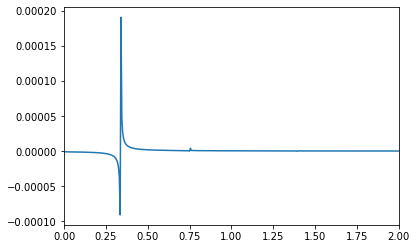

In [261]:
xt = np.real(scipy.fft.ifft(xf))
plt.plot(t, xt)
plt.xlim([0,2])

In [262]:
b,a = signal.butter(4, [0.15, 0.27], btype='bandpass')
xt_filt = signal.filtfilt(b,a,xt)

(0.0, 2.0)

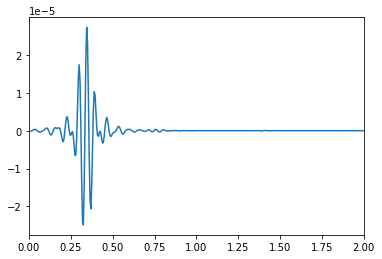

In [264]:
plt.plot(t, xt_filt)
plt.xlim([0,2])

## Loop through different ranges

In [351]:
def calc_ir(arrivals, fs=200, L=30):
    '''
    Parameters
    ----------
    arrivals : pd.DataFrame
        calculated from arlpy.uwpm
    fs : float
        sampling frequency
    L : float
        length of segment in seconds
    
    Returns
    -------
    ir : np.array
        impulse respose
    '''
    
    t, _, f = pyat_tools.get_freq_time_vectors(fs, L, verbose=False)
    
    xf = np.zeros(t.shape, dtype=complex)
    xf = np.zeros(t.shape, dtype=complex)
    for index, arrival in arrivals.iterrows():
        xf += arrival['arrival_amplitude']*np.exp(-1j*(2*np.pi*f)*np.real(arrival['time_of_arrival']))
    
    xt = np.real(scipy.fft.ifft(xf))
    
    return t,xt

In [376]:
ranges = np.linspace(30,3000,100)
pts = []

b,a = signal.butter(4, [0.15, 0.27], btype='bandpass')

for k in tqdm(range(len(ranges))):
    
    range_idx = np.argmin(np.abs(bathy[:,0] - ranges[k]))
    env = pm.create_env2d(
        depth=bathy,
        soundspeed=ssp,
        bottom_soundspeed=1450,
        bottom_density=1200,
        bottom_absorption=1.0,
        tx_depth= bathy[0][1] - 0.1,
        rx_depth= bathy[range_idx][1]-0.1,
        rx_range=ranges[k],
    )
    
    arrivals = pm.compute_arrivals(env)
    t,x = calc_ir(arrivals, fs=200, L=30)
    
    pts.append(signal.filtfilt(b,a,x))

  3%|█▎                                         | 3/100 [00:00<00:03, 27.45it/s]

STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details


  6%|██▌                                        | 6/100 [00:00<00:06, 14.44it/s]

STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details


  8%|███▍                                       | 8/100 [00:00<00:09,  9.40it/s]

STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details


 10%|████▏                                     | 10/100 [00:01<00:14,  6.19it/s]

STOP Fatal Error: Check the print file for details


 11%|████▌                                     | 11/100 [00:01<00:18,  4.88it/s]

STOP Fatal Error: Check the print file for details


 12%|█████                                     | 12/100 [00:02<00:21,  4.01it/s]

STOP Fatal Error: Check the print file for details


 13%|█████▍                                    | 13/100 [00:02<00:26,  3.30it/s]

STOP Fatal Error: Check the print file for details


 14%|█████▉                                    | 14/100 [00:03<00:33,  2.56it/s]

STOP Fatal Error: Check the print file for details


 15%|██████▎                                   | 15/100 [00:03<00:40,  2.12it/s]

STOP Fatal Error: Check the print file for details


 16%|██████▋                                   | 16/100 [00:04<00:46,  1.81it/s]

STOP Fatal Error: Check the print file for details


 17%|███████▏                                  | 17/100 [00:05<00:53,  1.57it/s]

STOP Fatal Error: Check the print file for details


 18%|███████▌                                  | 18/100 [00:06<01:01,  1.34it/s]

STOP Fatal Error: Check the print file for details


 19%|███████▉                                  | 19/100 [00:07<01:05,  1.23it/s]

STOP Fatal Error: Check the print file for details


 20%|████████▍                                 | 20/100 [00:08<01:12,  1.11it/s]

STOP Fatal Error: Check the print file for details


 21%|████████▊                                 | 21/100 [00:09<01:21,  1.03s/it]

STOP Fatal Error: Check the print file for details


 22%|█████████▏                                | 22/100 [00:11<01:27,  1.12s/it]

STOP Fatal Error: Check the print file for details


 23%|█████████▋                                | 23/100 [00:12<01:38,  1.28s/it]

STOP Fatal Error: Check the print file for details


 24%|██████████                                | 24/100 [00:14<01:45,  1.38s/it]

STOP Fatal Error: Check the print file for details


 25%|██████████▌                               | 25/100 [00:16<01:54,  1.53s/it]

STOP Fatal Error: Check the print file for details


 26%|██████████▉                               | 26/100 [00:18<02:04,  1.68s/it]

STOP Fatal Error: Check the print file for details


 27%|███████████▎                              | 27/100 [00:20<02:17,  1.89s/it]

STOP Fatal Error: Check the print file for details


 28%|███████████▊                              | 28/100 [00:23<02:23,  1.99s/it]

STOP Fatal Error: Check the print file for details


 29%|████████████▏                             | 29/100 [00:25<02:32,  2.15s/it]

STOP Fatal Error: Check the print file for details


 30%|████████████▌                             | 30/100 [00:28<02:39,  2.28s/it]

STOP Fatal Error: Check the print file for details


 31%|█████████████                             | 31/100 [00:30<02:46,  2.42s/it]

STOP Fatal Error: Check the print file for details


 32%|█████████████▍                            | 32/100 [00:33<02:56,  2.60s/it]

STOP Fatal Error: Check the print file for details


 33%|█████████████▊                            | 33/100 [00:37<03:08,  2.81s/it]

STOP Fatal Error: Check the print file for details


 34%|██████████████▎                           | 34/100 [00:40<03:18,  3.00s/it]

STOP Fatal Error: Check the print file for details


 35%|██████████████▋                           | 35/100 [00:44<03:22,  3.11s/it]

STOP Fatal Error: Check the print file for details


 36%|███████████████                           | 36/100 [00:47<03:33,  3.34s/it]

STOP Fatal Error: Check the print file for details


 37%|███████████████▌                          | 37/100 [00:51<03:39,  3.48s/it]

STOP Fatal Error: Check the print file for details


 38%|███████████████▉                          | 38/100 [00:55<03:47,  3.68s/it]

STOP Fatal Error: Check the print file for details


 39%|████████████████▍                         | 39/100 [01:00<04:01,  3.96s/it]

STOP Fatal Error: Check the print file for details


 40%|████████████████▊                         | 40/100 [01:05<04:08,  4.15s/it]

STOP Fatal Error: Check the print file for details


 41%|█████████████████▏                        | 41/100 [01:09<04:14,  4.31s/it]

STOP Fatal Error: Check the print file for details


 42%|█████████████████▋                        | 42/100 [01:14<04:19,  4.48s/it]

STOP Fatal Error: Check the print file for details


 43%|██████████████████                        | 43/100 [01:20<04:30,  4.75s/it]

STOP Fatal Error: Check the print file for details


 44%|██████████████████▍                       | 44/100 [01:25<04:40,  5.01s/it]

STOP Fatal Error: Check the print file for details


 45%|██████████████████▉                       | 45/100 [01:32<04:58,  5.42s/it]

STOP Fatal Error: Check the print file for details


 46%|███████████████████▎                      | 46/100 [01:38<05:05,  5.66s/it]

STOP Fatal Error: Check the print file for details


 47%|███████████████████▋                      | 47/100 [01:44<05:08,  5.82s/it]

STOP Fatal Error: Check the print file for details


 48%|████████████████████▏                     | 48/100 [01:51<05:14,  6.05s/it]

STOP Fatal Error: Check the print file for details


 49%|████████████████████▌                     | 49/100 [01:57<05:15,  6.18s/it]

STOP Fatal Error: Check the print file for details


 50%|█████████████████████                     | 50/100 [02:04<05:18,  6.37s/it]

STOP Fatal Error: Check the print file for details


 51%|█████████████████████▍                    | 51/100 [02:11<05:27,  6.68s/it]

STOP Fatal Error: Check the print file for details


 52%|█████████████████████▊                    | 52/100 [02:19<05:39,  7.07s/it]

STOP Fatal Error: Check the print file for details


 53%|██████████████████████▎                   | 53/100 [02:27<05:46,  7.38s/it]

STOP Fatal Error: Check the print file for details


 54%|██████████████████████▋                   | 54/100 [02:36<05:52,  7.67s/it]

STOP Fatal Error: Check the print file for details


 55%|███████████████████████                   | 55/100 [02:44<05:57,  7.93s/it]

STOP Fatal Error: Check the print file for details


 56%|███████████████████████▌                  | 56/100 [02:53<06:00,  8.20s/it]

STOP Fatal Error: Check the print file for details


 57%|███████████████████████▉                  | 57/100 [03:02<06:00,  8.38s/it]

STOP Fatal Error: Check the print file for details


 58%|████████████████████████▎                 | 58/100 [03:12<06:13,  8.89s/it]

STOP Fatal Error: Check the print file for details


 59%|████████████████████████▊                 | 59/100 [03:22<06:18,  9.23s/it]

STOP Fatal Error: Check the print file for details


 60%|█████████████████████████▏                | 60/100 [03:32<06:25,  9.63s/it]

STOP Fatal Error: Check the print file for details


 61%|█████████████████████████▌                | 61/100 [03:43<06:22,  9.82s/it]

STOP Fatal Error: Check the print file for details


 62%|██████████████████████████                | 62/100 [03:53<06:21, 10.04s/it]

STOP Fatal Error: Check the print file for details


 63%|██████████████████████████▍               | 63/100 [04:05<06:28, 10.50s/it]

STOP Fatal Error: Check the print file for details


 64%|██████████████████████████▉               | 64/100 [04:16<06:27, 10.75s/it]

STOP Fatal Error: Check the print file for details


 65%|███████████████████████████▎              | 65/100 [04:28<06:24, 10.98s/it]

STOP Fatal Error: Check the print file for details


 66%|███████████████████████████▋              | 66/100 [04:40<06:25, 11.32s/it]

STOP Fatal Error: Check the print file for details


 67%|████████████████████████████▏             | 67/100 [04:52<06:26, 11.70s/it]

STOP Fatal Error: Check the print file for details


 68%|████████████████████████████▌             | 68/100 [05:06<06:30, 12.19s/it]

STOP Fatal Error: Check the print file for details


 69%|████████████████████████████▉             | 69/100 [05:19<06:24, 12.42s/it]

STOP Fatal Error: Check the print file for details


 70%|█████████████████████████████▍            | 70/100 [05:32<06:21, 12.72s/it]

STOP Fatal Error: Check the print file for details


 71%|█████████████████████████████▊            | 71/100 [05:46<06:18, 13.04s/it]

STOP Fatal Error: Check the print file for details


 72%|██████████████████████████████▏           | 72/100 [06:00<06:12, 13.31s/it]

STOP Fatal Error: Check the print file for details


 73%|██████████████████████████████▋           | 73/100 [06:14<06:06, 13.58s/it]

STOP Fatal Error: Check the print file for details


 74%|███████████████████████████████           | 74/100 [06:29<05:59, 13.84s/it]

STOP Fatal Error: Check the print file for details


 75%|███████████████████████████████▌          | 75/100 [06:43<05:52, 14.10s/it]

STOP Fatal Error: Check the print file for details


 76%|███████████████████████████████▉          | 76/100 [06:58<05:45, 14.40s/it]

STOP Fatal Error: Check the print file for details


 77%|████████████████████████████████▎         | 77/100 [07:14<05:39, 14.77s/it]

STOP Fatal Error: Check the print file for details


 78%|████████████████████████████████▊         | 78/100 [07:31<05:38, 15.39s/it]

STOP Fatal Error: Check the print file for details


 79%|█████████████████████████████████▏        | 79/100 [07:48<05:33, 15.86s/it]

STOP Fatal Error: Check the print file for details


 80%|█████████████████████████████████▌        | 80/100 [08:04<05:22, 16.12s/it]

STOP Fatal Error: Check the print file for details


 81%|██████████████████████████████████        | 81/100 [08:23<05:18, 16.76s/it]

STOP Fatal Error: Check the print file for details


 82%|██████████████████████████████████▍       | 82/100 [08:42<05:14, 17.50s/it]

STOP Fatal Error: Check the print file for details


 83%|██████████████████████████████████▊       | 83/100 [09:00<04:59, 17.63s/it]

STOP Fatal Error: Check the print file for details


 84%|███████████████████████████████████▎      | 84/100 [09:18<04:45, 17.86s/it]

STOP Fatal Error: Check the print file for details


 85%|███████████████████████████████████▋      | 85/100 [09:37<04:33, 18.25s/it]

STOP Fatal Error: Check the print file for details


 86%|████████████████████████████████████      | 86/100 [09:58<04:24, 18.87s/it]

STOP Fatal Error: Check the print file for details


 87%|████████████████████████████████████▌     | 87/100 [10:17<04:07, 19.02s/it]

STOP Fatal Error: Check the print file for details


 88%|████████████████████████████████████▉     | 88/100 [10:38<03:53, 19.43s/it]

STOP Fatal Error: Check the print file for details


 89%|█████████████████████████████████████▍    | 89/100 [10:58<03:36, 19.70s/it]

STOP Fatal Error: Check the print file for details


 90%|█████████████████████████████████████▊    | 90/100 [11:19<03:22, 20.24s/it]

STOP Fatal Error: Check the print file for details


 91%|██████████████████████████████████████▏   | 91/100 [11:41<03:05, 20.59s/it]

STOP Fatal Error: Check the print file for details


 92%|██████████████████████████████████████▋   | 92/100 [12:03<02:48, 21.00s/it]

STOP Fatal Error: Check the print file for details


 93%|███████████████████████████████████████   | 93/100 [12:26<02:32, 21.73s/it]

STOP Fatal Error: Check the print file for details


 94%|███████████████████████████████████████▍  | 94/100 [12:49<02:12, 22.06s/it]

STOP Fatal Error: Check the print file for details


 95%|███████████████████████████████████████▉  | 95/100 [13:13<01:52, 22.55s/it]

STOP Fatal Error: Check the print file for details


 96%|████████████████████████████████████████▎ | 96/100 [13:36<01:30, 22.74s/it]

STOP Fatal Error: Check the print file for details


 97%|████████████████████████████████████████▋ | 97/100 [14:00<01:09, 23.15s/it]

STOP Fatal Error: Check the print file for details


 98%|█████████████████████████████████████████▏| 98/100 [14:25<00:47, 23.76s/it]

STOP Fatal Error: Check the print file for details


 99%|█████████████████████████████████████████▌| 99/100 [14:51<00:24, 24.49s/it]

STOP Fatal Error: Check the print file for details


100%|█████████████████████████████████████████| 100/100 [15:17<00:00,  9.17s/it]


In [377]:
pts_n = np.array(pts)

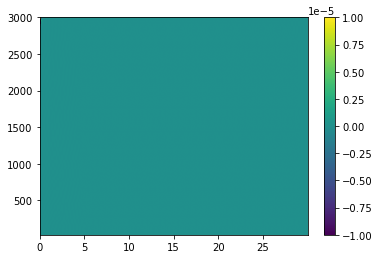

In [382]:
plt.imshow(pts_n, extent=(t[0], t[-1], ranges[0], ranges[-1]), aspect='auto', vmax=1e-6, vmin=-1e)
plt.colorbar()

## Build Simulation Script

### Download HYCOM data

In [14]:
fn = '/datadrive/DAS/south_DAS_latlondepth.txt'
geo = pd.read_csv(fn)
geo['distance'] = geo['index']*2.0419046878814697

In [49]:
files = [
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t000_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t003_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t006_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t009_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t012_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t015_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t018_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110112_t021_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t000_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t003_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t006_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t009_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t012_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t015_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t018_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110212_t021_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t000_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t003_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t006_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t009_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t012_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t015_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t018_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110312_t021_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t000_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t003_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t006_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t009_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t012_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t015_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t018_ts3z.nc',
    'ftp://ftp.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2021/hycom_glby_930_2021110412_t021_ts3z.nc',
]

thredds_base = 'https://tds.hycom.org/thredds/dodsC'

for file in tqdm(files):
    file_path = thredds_base + file[19:]
    file_name = file[-38:]
    
    ds = xr.open_dataset(thredds_base + file[19:], decode_times=False)
    ds_slice = ds.loc[{'lat':slice(geo.lat.min(), geo.lat.max()), 'lon':slice(geo.lon.min()+360, geo.lon.max()+360)}]
    ds_slice.to_netcdf(f'/datadrive/HYCOM_data/DAS_ooi_South_Tx/{file_name}')

100%|███████████████████████████████████████████████████████████████| 32/32 [10:04<00:00, 18.89s/it]


### Build Simulation Loop

In [50]:
fn = '/datadrive/DAS/south_DAS_latlondepth.txt'
geo = pd.read_csv(fn)
geo['distance'] = geo['index']*2.0419046878814697

In [56]:
hycom = xr.open_mfdataset('/datadrive/HYCOM_data/DAS_ooi_South_Tx/*.nc', decode_times=False)

In [275]:
arrivals_forward = []
arrivals_backward = []

for k in tqdm(range(1,15)):
    idx1 = (geo['index']-k*3000).abs().argmin()
    idx2 = (geo['index']-(k+1)*3000).abs().argmin()
    
    lat = geo.loc[idx1:idx2].lat.mean()
    lon = geo.loc[idx1:idx2].lon.mean()
    
    # Get SSP
    sspx = sw.soundspeed(hycom.salinity, hycom.water_temp, hycom.depth).sel({'lat':lat, 'lon':lon}, method='nearest')
    ssp = pyat_tools.convert_SSP_arlpy(sspx, 0)[1:,:]
    ssp = np.vstack((ssp, np.array([5000,ssp[-1,1]])))
    
    # Get Bathy 
    bathy_pd = geo.loc[idx1:idx2][['distance','depth']]
    bathy_pd['depth'] = bathy_pd['depth']*-1
    bathy_pd['distance'] = bathy_pd['distance'] - bathy_pd.loc[idx1+1500]['distance']
    bathy_pd['distance'] = bathy_pd['distance']
    bathy = np.array(bathy_pd)

    bathy_backward = bathy[:1501,:]
    bathy_backward[:,0] = -1*bathy_backward[:,0]
    bathy_backward = np.flip(bathy_backward, axis=0)
    bathy_forward = bathy[1500:-1,:]

    depth_interp_forward = interpolate.interp1d(bathy_forward[:,0], bathy_forward[:,1], kind='cubic')
    depth_interp_backward = interpolate.interp1d(bathy_backward[:,0], bathy_backward[:,1], kind='cubic')
    ranges = np.linspace(5,3000,50)
    

    for n in range(len(ranges)):
        # Define environment
        env_forward = pm.create_env2d(
            depth=bathy_forward,
            soundspeed=ssp,
            bottom_soundspeed=1450,
            bottom_density=1200,
            bottom_absorption=1.0,
            tx_depth=bathy_forward[0,1]-0.01,
            rx_range = ranges[n],
            rx_depth = depth_interp_forward(ranges[n])-0.01
        )
        
        # Define environment
        env_backward = pm.create_env2d(
            depth=bathy_backward,
            soundspeed=ssp,
            bottom_soundspeed=1450,
            bottom_density=1200,
            bottom_absorption=1.0,
            tx_depth=bathy_backward[0,1]-0.01,
            rx_range = ranges[n],
            rx_depth = depth_interp_backward(ranges[n])-0.01
        )
        
        arrivals_forward.append(pm.compute_arrivals(env_forward))
        arrivals_backward.append(pm.compute_arrivals(env_backward))
        
results = {'arrivals_forward':arrivals_forward, 'arrivals_backward':arrivals_backward}

fn = f'/datadrive/simulation/DAS/{k*3000}-{(k+1)*3000}_arrivals.pkl'

with open(fn, 'wb') as f:
    pickle.dump(results, f)

STOP Fatal Error: Check the print file for details
STOP Fatal Error: Check the print file for details


In [278]:
pm.plot_env(env_forward)
pm.plot_env(env_backward)

In [277]:
arrivals_forward[0]

,tx_depth_ndx,rx_depth_ndx,rx_range_ndx,tx_depth,rx_depth,rx_range,arrival_number,arrival_amplitude,time_of_arrival,angle_of_departure,angle_of_arrival,surface_bounces,bottom_bounces
1,0,0,0,56.928242,56.930317,5.0,0,0.110203+0.000000j,0.003353,-0.267559,-0.174395,0,0
2,0,0,0,56.928242,56.930317,5.0,1,-0.194777-0.034903j,0.003353,0.267559,-0.196972,0,1


In [273]:
arrivals_forward = pm.compute_arrivals(env_forward)
arrivals_backward = pm.compute_arrivals(env_backward)

STOP Fatal Error: Check the print file for details


In [214]:
geo.loc[idx1+1500]['distance']

9188.571095466614

In [253]:
# Get Bathy 
bathy_pd = geo.loc[idx1:idx2][['distance','depth']]
bathy_pd['depth'] = bathy_pd['depth']*-1
bathy_pd['distance'] = bathy_pd['distance'] - bathy_pd.loc[idx1+1500]['distance']
bathy_pd['distance'] = bathy_pd['distance']
bathy = np.array(bathy_pd)

bathy_backward = bathy[:1500,:]
bathy_backward[:,0] = -1*bathy_backward[:,0]
bathy_backward = bathy_backward

bathy_forward = bathy[1501:-1,:]

In [254]:
bathy_backward

array([[3.06285703e+03, 4.24634720e+01],
       [3.06081513e+03, 4.24789740e+01],
       [3.05877322e+03, 4.24954870e+01],
       ...,
       [6.12571406e+00, 5.69376970e+01],
       [4.08380938e+00, 5.69375080e+01],
       [2.04190469e+00, 5.69376690e+01]])

In [199]:
bathy_pd = geo.loc[idx1:idx2][['distance','depth']]

In [208]:
(geo['index']-6000).abs().argmin()

5058

In [210]:
geo.loc[5058]

index        6000.000000
lat            45.185501
lon          -124.095060
depth         -78.795780
distance    12251.428127
Name: 5058, dtype: float64

In [179]:
arrivals = pm.compute_arrivals(env_forward)

STOP Fatal Error: Check the print file for details


In [8]:
def calc_ir(arrivals, fs=200, L=30):
    '''
    Parameters
    ----------
    arrivals : pd.DataFrame
        calculated from arlpy.uwpm
    fs : float
        sampling frequency
    L : float
        length of segment in seconds
    
    Returns
    -------
    ir : np.array
        impulse respose
    '''
    
    t, _, f = pyat_tools.get_freq_time_vectors(fs, L, verbose=False)
    
    xf = np.zeros(t.shape, dtype=complex)
    xf = np.zeros(t.shape, dtype=complex)
    for index, arrival in arrivals.iterrows():
        xf += arrival['arrival_amplitude']*np.exp(-1j*(2*np.pi*f)*np.real(arrival['time_of_arrival']))
    
    xt = np.real(scipy.fft.ifft(xf))
    
    return t,xt

In [170]:
depth_interp(np.linspace(0,3000,100)+1)-0.01

array([42.4621756 , 42.83893142, 43.22811667, 43.48995229, 43.47237527,
       43.42953603, 43.46022268, 43.65949489, 43.86218796, 43.99202913,
       43.99404771, 43.9645982 , 43.93106276, 43.91665868, 43.91516617,
       43.92448391, 43.93001577, 43.94254851, 44.04163502, 44.21590362,
       44.38260142, 44.42565809, 44.38828144, 44.33261607, 44.34708317,
       44.39614694, 44.44133849, 44.36203689, 44.27242736, 44.2220249 ,
       44.30327311, 44.39517523, 44.43706556, 44.35301232, 44.31808363,
       44.46590835, 44.93934385, 45.47549573, 45.92785821, 46.2218498 ,
       46.42634386, 46.50529853, 46.49351031, 46.44855187, 46.43927745,
       46.44678084, 46.45014898, 46.40214945, 46.37720301, 46.43689566,
       46.69325788, 47.07232392, 47.54934974, 48.10657759, 48.64839776,
       49.06774245, 49.27980309, 49.39954107, 49.45369735, 49.46287009,
       49.44423415, 49.4352852 , 49.43836408, 49.43968986, 49.44018254,
       49.44013998, 49.4399592 , 49.44003794, 49.44019262, 49.44

In [168]:
tloss = pm.compute_transmission_loss(env)

STOP Fatal Error: Check the print file for details


In [169]:
tloss

,1000.0
10.0,-0.000556+0.000058j


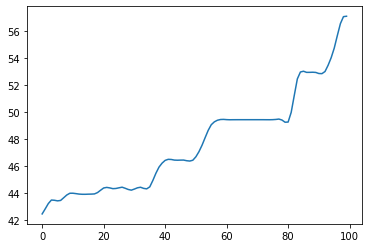

In [164]:
plt.plot(depth_interp(np.linspace(0,3000,100)+1)-0.01)

In [152]:
depth_interp(1000)

array(44.36528348)

In [165]:
pm.plot_env(env_forward)

<AxesSubplot:xlabel='distance'>

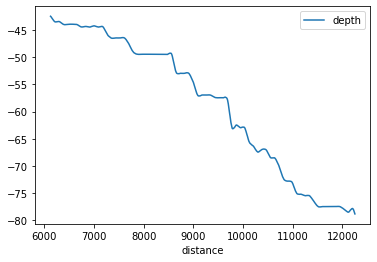

In [66]:
geo.loc[idx1:idx2].plot(x='distance', y='depth')

# Debug

In [177]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import arlpy.uwapm as pm
import arlpy.plot as aplt
import numpy as np
from oceans.sw_extras import sw_extras as sw
from pyat_tools import pyat_tools
from scipy import signal
import scipy
from tqdm import tqdm
import ODLintake
from scipy import interpolate
from tqdm import tqdm
import pickle

fn = '/datadrive/DAS/south_DAS_latlondepth.txt'
geo = pd.read_csv(fn)
geo['distance'] = geo['index']*2.0419046878814697

hycom = xr.open_mfdataset(
    '/datadrive/HYCOM_data/DAS_ooi_South_Tx/*.nc', decode_times=False)

arrivals_forward = []
arrivals_backward = []

#for k in tqdm(range(1, 15)):
for k in range(1,15):
    idx1 = (geo['index']-k*3000).abs().argmin()
    idx2 = (geo['index']-(k+1)*3000).abs().argmin()

    lat = geo.loc[idx1:idx2].lat.mean()
    lon = geo.loc[idx1:idx2].lon.mean()

    # Get SSP
    sspx = sw.soundspeed(hycom.salinity, hycom.water_temp, hycom.depth).sel(
        {'lat': lat, 'lon': lon}, method='nearest')
    ssp = pyat_tools.convert_SSP_arlpy(sspx, 0)[1:, :]
    ssp = np.vstack((ssp, np.array([5000, ssp[-1, 1]])))

    # Get Bathy
    bathy_pd = geo.loc[idx1:idx2][['distance', 'depth']]
    bathy_pd['depth'] = bathy_pd['depth']*-1
    bathy_pd['distance'] = bathy_pd['distance'] - \
        bathy_pd.loc[idx1+1500]['distance']
    bathy_pd['distance'] = bathy_pd['distance']
    bathy = np.array(bathy_pd)

    bathy_backward = bathy[:1501, :]
    bathy_backward[:, 0] = -1*bathy_backward[:, 0]
    bathy_backward = np.flip(bathy_backward, axis=0)
    bathy_forward = bathy[1500:-1, :]

    depth_interp_forward = interpolate.interp1d(
        bathy_forward[:, 0], bathy_forward[:, 1], kind='cubic')
    depth_interp_backward = interpolate.interp1d(
        bathy_backward[:, 0], bathy_backward[:, 1], kind='cubic')
    
    ranges = np.linspace(5,2999,50)
    
    test1 = depth_interp_forward(ranges)
    test2 = depth_interp_backward(ranges)
    
    break

In [31]:
fn = '/datadrive/simulation/DAS/27000-30000_arrivals.pkl'
with open(fn, 'rb') as f:
    arrivals = pickle.load(f)

In [32]:
len(arrivals['arrivals_forward'])

50

In [33]:
irs_forward = []
irs_backward = []

for k in range(50):
    try:
        t, ir_forward = calc_ir(arrivals['arrivals_forward'][k])
    except AttributeError:
        ir_forward = np.ones(6000)*np.nan
    
    try:
        t, ir_backward = calc_ir(arrivals['arrivals_backward'][k])
    except AttributeError:
        ir_backward = np.ones(6000)*np.nan
    
    irs_forward.append(ir_forward)
    irs_backward.append(ir_backward)


In [34]:
irs = np.vstack((np.flip(np.array(irs_backward), axis=0), np.array(irs_forward)))

b,a = signal.butter(4, [15/100,27/100], btype='bandpass')
irs20 = signal.filtfilt(b,a,irs, axis=1)

Text(0.5, 0, 'delay [s]')

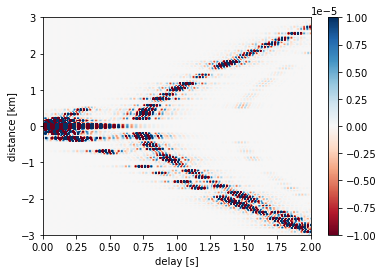

In [36]:
plt.imshow(irs20, aspect='auto', vmax=1e-5, vmin=-1e-5,  cmap='RdBu', extent=[0,30,3,-3])
plt.colorbar()
plt.ylim([-3,3])
plt.xlim([0,2])
plt.ylabel('distance [km]')
plt.xlabel('delay [s]')

Text(0.5, 0, 'delay [s]')

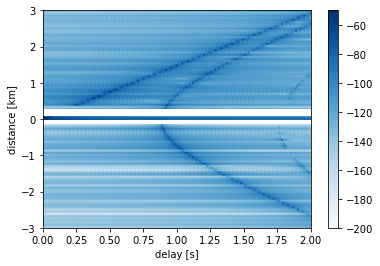

In [28]:
plt.imshow(20*np.log10(np.abs(signal.hilbert(irs))), vmax=-50, vmin=-200, aspect='auto', cmap='Blues', extent=[0,30,3,-3])
plt.colorbar()
plt.ylim([-3,3])
plt.xlim([0,2])
plt.ylabel('distance [km]')
plt.xlabel('delay [s]')

In [276]:
for k in range(1,15):
    print(k*3000, (k+1)*3000)

3000 6000
6000 9000
9000 12000
12000 15000
15000 18000
18000 21000
21000 24000
24000 27000
27000 30000
30000 33000
33000 36000
36000 39000
39000 42000
42000 45000
